# Function Approximation in RL : LSTD(lambda)

**Due date : 20/03/2018**

**By : Julien Roy and David Kanaa**

In [1]:
import gym
import time

import numpy as np
import pycolab

from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction

# Implementations

In [2]:
def show_board(obs, board_footprints=None, leave_footprints=False):
    
    # Represents the agent as a yellow dot on the board
    board = 100 * np.array(obs.layers['P'], dtype=np.float)
    
    # Indicates in which states the agent went
    if leave_footprints:
        new_footprints = 20 * np.array(obs.layers['P'], dtype=np.float)
    
        if board_footprints is not None:
            board_footprints += new_footprints
            board += board_footprints
        else:
            board_footprints = new_footprints
    
    # Adds the Goal as a green dot on the board (if there is one)
    if 'G' in obs.layers:
        board += 80 * np.array(obs.layers['G'], dtype=np.float)

    # Creates the figure
    plt.figure(figsize=5 * np.array(board.shape))
    plt.imshow(board)
    plt.axis('off')
    plt.show()
    
    return board_footprints

### Environment - Boyan's Chain

In [3]:
BOYAN_CHAIN = ['P           G']

def make_BoyanChain(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite_BoyanChain})

class PlayerSprite_BoyanChain(prefab_sprites.MazeWalker):

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite_BoyanChain, self).__init__(corner, position, character, impassable='#')
    
    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things   # Unused in this application.
        _, position = self.position
        
        if actions == 0: # Fake action.. just to avoid making a move during its_showtime() call
            
            # From the last state before the Goal
            if layers["G"][0, position + 1]:
                self._east(board, the_plot)   # single jump east
                the_plot.add_reward(-2.0)

            # From any other state 
            else:
                # Each one of the 2 possible transitions have a probability of 0.5
                if np.random.rand() > 0.5:    # single jump east
                    self._east(board, the_plot)
                else:                         # double jump east
                    self._east(board, the_plot)
                    self._east(board, the_plot)

                # Any transition from those states give a reward of -3
                the_plot.add_reward(-3.0)
                 
        # Check if our agent is on the goal position
        if layers["G"][self.position]:
            the_plot.terminate_episode()

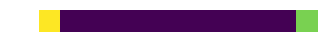

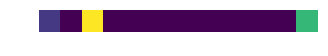

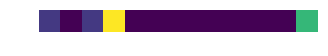

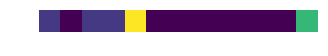

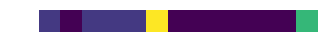

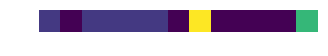

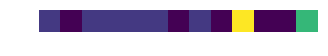

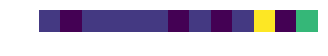

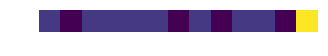

GAME OVER
Undiscounted Return : -24.0


In [4]:
undiscounted_return = 0

game = make_BoyanChain(BOYAN_CHAIN)
obs, reward, gamma = game.its_showtime()
board_footprints = show_board(obs, leave_footprints=True)
while not(game.game_over):
    obs, reward, gamma = game.play(0)
    undiscounted_return += reward
    board_footprints = show_board(obs, board_footprints, leave_footprints=True)
print('GAME OVER')
print('Undiscounted Return : {}'.format(undiscounted_return))

### Environment - Bradtke's 5-states Domain

In [5]:
BRADTKE_DOMAIN = ['P    ']

boyan_features = np.array([
            [1.00, 0.00, 0.00, 0.00],
            [0.75, 0.25, 0.00, 0.00],
            [0.50, 0.50, 0.00, 0.00],
            [0.25, 0.75, 0.00, 0.00],
            [0.00, 1.00, 0.00, 0.00],
            [0.00, 0.75, 0.25, 0.00],
            [0.00, 0.50, 0.50, 0.00],
            [0.00, 0.25, 0.75, 0.00],
            [0.00, 0.00, 1.00, 0.00],
            [0.00, 0.00, 0.75, 0.25],
            [0.00, 0.00, 0.50, 0.50],
            [0.00, 0.00, 0.25, 0.75],
            [0.00, 0.00, 0.00, 1.00],
        ])

def make_BradtkeDomain(art):
    """Builds and returns game."""
    return ascii_art.ascii_art_to_game(art, what_lies_beneath=' ', sprites={'P': PlayerSprite_BradtkeDomain})

class PlayerSprite_BradtkeDomain(prefab_sprites.MazeWalker):

    def __init__(self, corner, position, character):
        """Inform superclass that the '#' delimits the walls."""
        super(PlayerSprite_BradtkeDomain, self).__init__(corner, position, character, impassable='#')
        
        self.transition_matrix = np.array([
            [0.42, 0.13, 0.14, 0.03, 0.28],
            [0.25, 0.08, 0.16, 0.35, 0.15],
            [0.08, 0.20, 0.33, 0.17, 0.22],
            [0.36, 0.05, 0.00, 0.51, 0.07],
            [0.17, 0.24, 0.19, 0.18, 0.22]
        ])
        
        self.state_features = np.array([
            [74.29, 34.61, 73.48, 53.29,  7.79],
            [61.60, 48.07, 34.68, 36.19, 82.02],
            [97.00,  4.88,  8.51, 87.89,  5.17],
            [41.10, 40.13, 64.63, 92.67, 31.09],
            [ 7.76, 79.82, 43.78,  8.56, 61.11]
        ])
        
        self.reward_matrix = np.array([
            [104.66, 29.69,  82.36,  37.49, 68.82],
            [ 75.86, 29.24, 100.37,   0.31, 35.99],
            [ 57.68, 65.66,  56.95, 100.44, 47.63],
            [ 96.23, 14.01,   0.88,  89.77, 66.77],
            [ 70.35, 23.69,  73.41,  70.70, 85.41]
        ])
    
    def update(self, actions, board, layers, backdrop, things, the_plot):
        del backdrop, things   # Unused in this application.
        _, position = self.position
        
        if actions == 0: # Fake action.. just to avoid making a move during its_showtime() call

            # New position is sampled from a multinouilli distribution parametrized by the environment's transition matrix
            new_position = np.argmax(np.random.multinomial(n=1, pvals=self.transition_matrix[position, :]))
            
            # Receives a reward according to the reward matrix (deterministic reward associated with each transition)
            the_plot.add_reward(self.reward_matrix[position, new_position])
            
            # Move the agent to the new position
            self._teleport((0, new_position))

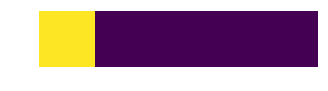

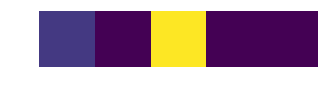

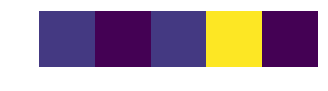

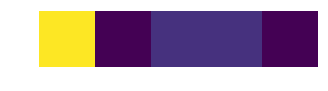

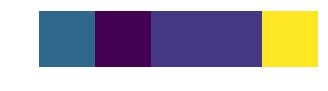

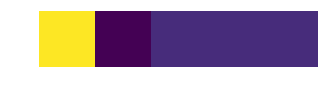

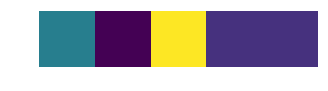

GAME OVER
Undiscounted Return : 500.56


In [6]:
undiscounted_return = 0

game = make_BradtkeDomain(BRADTKE_DOMAIN)
obs, reward, gamma = game.its_showtime()
board_footprints = show_board(obs, leave_footprints=True)

while undiscounted_return < 500:
    obs, reward, gamma = game.play(0)
    undiscounted_return += reward
    board_footprints = show_board(obs, board_footprints, leave_footprints=True)
print('GAME OVER')
print('Undiscounted Return : {:.2f}'.format(undiscounted_return))

## LSTD (in progess ...)

In [12]:
# an implementation of LSTD($\lambda$)
# given: a simulaton model, featurizer, and $\lambda$.
# output: vector $\beta$ so that $V^{\pi}(x) = \beta * \phi(x)
def _lstd(_model, _featurizer, _lambda):
    # set A = 0, b = 0, t = 0
    A, b, t = 0, 0, 0
    
    #
    for n in range(1000):
        # choose start state $x_t$
        obs, _, __ = _model.its_showtime()
        position = np.array(obs.layers['P'])
        state = np.unravel_index(position.argmax(), position.shape)
        print(state)
        
        # set $z_t = \phi(x_t)$
        eligibility = _featurizer(state)
        
        #
        while not _model.game_over:
            # simulate one step of the chain, producing a reward R_t and next state x_{t+1}
            obs, reward, _ = _model.play(0)
            position = np.array(obs.layers['P'])
            next_state = np.unravel_index(position.argmax(), position.shape)
            print(next_state)
            
            # set $A = A + z_t \cdot (\phi(x_t) - \phi(x_{t+1}))^T$
            A = A + np.dot( eligibility, (_featurizer(state) - _featurizer(next_state)).T )
            
            # set $b = b + z_t * R_t$
            b = b + (eligibility * reward)
            
            # set $z_{t+1} = lambda * z_t + \phi(x_{t+1})$
            eligibility = (_lambda * eligibility) + _featurizer(next_state)
            
            # set $t = t+1$
            t = t + 1
            
            #
            state = next_state
        
        # whenever padte coefficients are desired : set $\beta = A^{-1} \cdot b$ using SVD
        A_ = np.pinv(A)
        beta = np.dot(A_, b)
    
        print(beta.mean())

In [13]:
game = make_BoyanChain(BOYAN_CHAIN)
_lstd(game, lambda x: boyan_features[x, :], .4)

(0, 0)
(0, 1)
(0, 2)
(0, 4)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 11)
(0, 12)


AttributeError: module 'numpy' has no attribute 'pinv'

# Experiments

# Discussion

# Conclusion